In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from skimage import data, color, feature, transform
import skimage.data
from sklearn.datasets import fetch_lfw_people
from sklearn.feature_extraction.image import PatchExtractor
from itertools import chain
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import LinearSVC
from PIL import Image

plt.style.use('seaborn-v0_8-whitegrid')

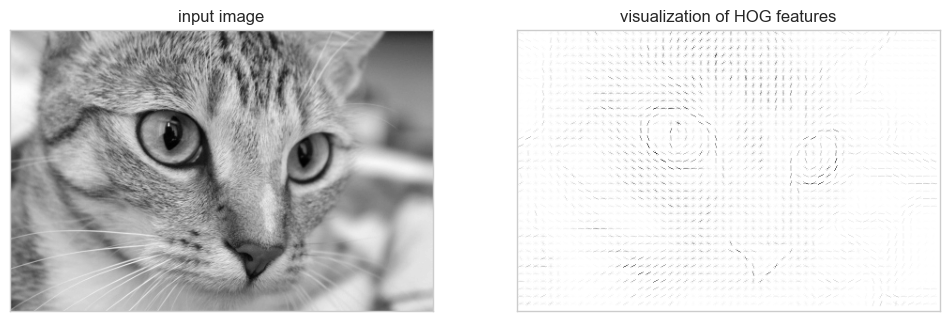

In [2]:
# one way to extract features is to use the Histogram of Oriented Gradients (HOG) descriptor which transforms image pixels into a vector representation that is sensitive to broadly informative image features to develop a facial detection pipeline
# hog involves the following steps:
# 1. Optionally pre-normalize images. This leads to features that resist dependence on variations in illumination.
# 2. Convolve the image with two filters that are sensitive to horizontal and vertical brightness gradients. These capture edge, contour, and texture information.
# 3. Subdivide the image into cells of a predetermined size, and compute a histogram of the gradient orientations within each cell.
# 4. Normalize the histograms in each cell by comparing to the block of neighboring cells. This further suppresses the effect of illumination across the image.
# 5. Construct a one-dimensional feature vector from the information in each cell.
# a fast hog extractor is built into the scikit-image project, and we can try it out relatively quickly and visualize the oriented gradients within each cell:
image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, visualize=True)
fig, ax = plt.subplots(1, 2, figsize=(12, 6), subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap="gray")
ax[0].set_title("input image")
ax[1].imshow(hog_vis)
ax[1].set_title("visualization of HOG features")

In [3]:
# hog in action a simple face detector
# using hog features we can build up a simple facial detection algo with any scikit-learn estimator; here we will use a linear support vector machine (refer to the scikit-learn documentation for more info on this)
# the steps are as follows:
# 1. Obtain a set of image thumbnails of faces to constitute "positive" training samples.
# 2. Obtain a set of image thumbnails of non-faces to constitute "negative" training samples.
# 3. Extract HOG features from these training samples.
# 4. Train a linear SVM classifier on these samples.
# 5. For an "unknown" image, pass a sliding window across the image, using the model to evaluate whether that window contains a face or not.
# 6. If detections overlap, combine them into a single window.

# step 1: obtain a set of positive training samples
# for this we can use the labeled faces in the wild dataset,
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

In [4]:
# obtain a set of negative training samples
# next we need a similarly sized set of thumbnails that do not have a face in them; one way to do this is to take any corpus of input images, and extract thumbnails from them at a variety of scales. we'll use some of the images shipped with scikit-image, along with a utility function to extract patches of a given size from an image
data.camera().shape

(512, 512)

In [5]:
imgs_to_use = [
    "camera",
    "text",
    "coins",
    "moon",
    "page",
    "clock",
    "immunohistochemistry",
    "chelsea",
    "coffee",
    "hubble_deep_field",
]
raw_images = (getattr(data, name)() for name in imgs_to_use)
images = [color.rgb2gray(image) if image.ndim == 3 else image for image in raw_images]

In [6]:
def extract_patches(img, N, scale=1, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(
        patch_size=extracted_patch_size, max_patches=N, random_state=0
    )
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size) for patch in patches])
    return patches


negative_patches = np.vstack(
    [extract_patches(im, 1000, scale) for im in images for scale in [0.5, 1.0, 2.0]]
)
negative_patches.shape

(30000, 62, 47)

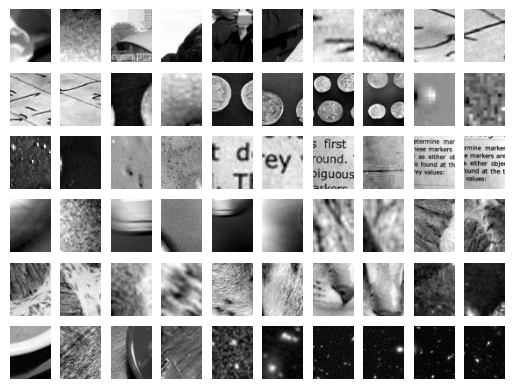

In [7]:
# now we have 30,000 suitable image patches that do not contain faces; let's take a look at a few to get an idea of what they look like
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap="gray")
    axi.axis("off")

In [8]:
# step 3: combine sets and extract HOG features
# now that we have these positive samples and negative samples, we can combine them and compute HOG features
X_train = np.array(
    [feature.hog(im) for im in chain(positive_patches, negative_patches)]
)
y_train = np.zeros(X_train.shape[0])
y_train[: positive_patches.shape[0]] = 1

In [9]:
X_train.shape

(43233, 1215)

In [10]:
# step 4: train a support vector machine
# next we use the tools we have been exploring in this chapter to create a classifier of thumbnail patches
# for such a high-dimensional binary classification task, a linear support vector machine is a good choice; we will use scikit-learn's LinearSVC, because in comparison to SVC it often has better scaling for large number of samples
# first lets use a simple Gaussian naive Bayes classifier to get a quick baseline
cross_val_score(GaussianNB(), X_train, y_train)

array([0.95732624, 0.972476  , 0.97340118, 0.97628961, 0.97490169])

In [11]:
# lets try the svm with a grid search over a few choices of the C parameter
grid = GridSearchCV(LinearSVC(dual=True), {"C": [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

/Users/russell/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/russell/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/russell/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/russell/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/russell/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/russell/miniconda3/envs/ML/lib/py

0.9885272700574659

In [12]:
grid.best_params_

{'C': 2.0}

In [13]:
# lets take the best estimator and re-train it on the full dataset
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=2.0, dual=True)

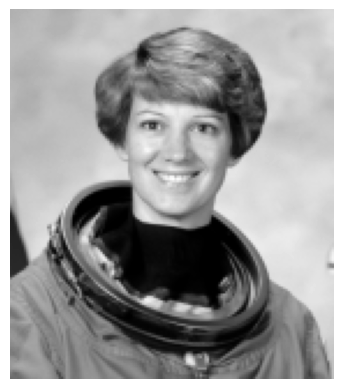

In [14]:
# step 5: find faces in a new image
# now that we have this model in place lets grab a new image and see how the model does. we will use one portion of the astronaut image for simplicity, and run a sliding window over it and evaluate each patch
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap="gray")
plt.axis("off")

In [15]:
# now we create a window that iterates over patches of this image, and compute HOG features for each patch
def sliding_window(
    img, patch_size=positive_patches[0].shape, istep=2, jstep=2, scale=1.0
):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i : i + Ni, j : j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch


indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(1911, 1215)

In [16]:
# finally we can take these HOG-featured patches and use our model to evaluate whether each patch contains a face
labels = model.predict(patches_hog)
labels.sum()

46.0

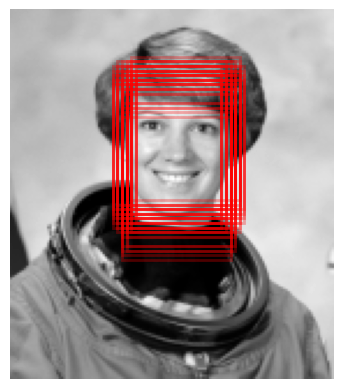

In [17]:
# we see that out of nearly 2,000 patches, we have found that 46 of them are positive detections. lets use the information we have about these patches to show where they lie on our test image, drawing them as rectangles
fig, ax = plt.subplots()
ax.imshow(test_image, cmap="gray")
ax.axis("off")

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(
        plt.Rectangle(
            (j, i), Nj, Ni, edgecolor="red", alpha=0.3, lw=2, facecolor="none"
        )
    )